In [4]:
library(tidyverse)
library(magrittr) # better handling of pipes
library(purrr) # to work with lists and map functions
library(glue) # to paste strings
library(stringr) # to hand strings
library(rvest) # rvest makes scraping easier
library(polite) # polite is the "polite" version of rvest
library(xml2) # makes it easier to work with HTML and XML from R
library(ggplot2)
library(httr)
library(visdat)
library(skimr)
library(zoo)

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.3     v dplyr   1.0.7
v tidyr   1.1.3     v stringr 1.4.0
v readr   2.0.0     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'magrittr'


The following object is masked from 'package:purrr':

    set_names


The following object is masked from 'package:tidyr':

    extract



Attaching package: 'glue'


The following object is masked from 'package:dplyr':

    collapse


Warning message:
"package 'rvest' was built under R version 4.1.1"

Attaching package: 'rvest'


The following object is masked from 'package:readr':

    guess_encoding




ERROR: Error in library(polite): there is no package called 'polite'


In [35]:
covid_case_df <- read_csv("data/Number_of_cases.csv")
hpi_df <- read_csv("data/household-living-costs-price-indexes-June-2021-quarter-time-series-indexes.csv")

covid_case_df %>% glimpse()
hpi_df %>% glimpse()


New names:
* `` -> ...1

Rows: 1554 Columns: 18

-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (13): ResourceID, Subject, Title, Description, Source, SourceURL, Frequ...
dbl   (3): ...1, Value, Multiplier
dttm  (1): Modified
date  (1): Period


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 45262 Columns: 11

-- Column specification --------------------------------------------------------
Delimiter: ","
chr (8): hlpi_name, series_ref, quarter, hlpi, nzhec, nzhec_name, nzhec_shor...
dbl (3): index, change.q, change.a


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



Rows: 1,554
Columns: 18
$ ...1        <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,~
$ ResourceID  <chr> "CPCOV2", "CPCOV2", "CPCOV2", "CPCOV2", "CPCOV2", "CPCOV2"~
$ Subject     <chr> "COVID-19", "COVID-19", "COVID-19", "COVID-19", "COVID-19"~
$ Title       <chr> "Number of Cases", "Number of Cases", "Number of Cases", "~
$ Description <chr> "COVID-19 cases in New Zealand (cumulative)", "COVID-19 ca~
$ Source      <chr> "Ministry of Health", "Ministry of Health", "Ministry of H~
$ SourceURL   <chr> "https://www.health.govt.nz/our-work/diseases-and-conditio~
$ Modified    <dttm> 2021-10-06 11:00:00, 2021-10-06 11:00:00, 2021-10-06 11:0~
$ Frequency   <chr> "Daily", "Daily", "Daily", "Daily", "Daily", "Daily", "Dai~
$ Var1        <chr> "Case status", "Case status", "Case status", "Case status"~
$ id          <chr> "3934f4da-e3ed-43c4-8656-441f49f9c7ca", "2a4fa96a-27a1-423~
$ Period      <date> 2020-02-28, 2020-02-29, 2020-03-01, 2020-03-02, 2020-03-0~
$ Duration    <c

In [221]:
convertToWeek <- function(date, format="%V-%Y") {
    return (strftime(date, format=format))
}

getFirstDayOfWeek <- function(date) {
    weekIndex = strtoi(convertToWeek(date, format="%V"), base=10L)
    year = convertToWeek(date, format="%Y")
    string <- paste(year, weekIndex, "1", sep="-") # 1 for Monday
    return (string)
}

getByStatus <- function(data, status, rename=FALSE) {
    result <- data %>% filter(Status==status)
    if (rename == TRUE) {
        result %<>% select(Value, Date) 
        names(result)[names(result) == 'Value'] <- status
    }
    return (result)
}

trim_Covid_Raw_df <-function(covid_df, option) {
    covid_df <- covid_df %>% rename(Status=Label1, Date=Period)
    covid_df %<>% mutate(
        Week = map_chr(Date, convertToWeek),
        Week_Index = map_chr(Date, getWeekIndex),
        Monday = map_chr(Date, getFirstDayOfWeek)
    )
    suppressWarnings( # There is not good record in raw data, see Failure in report
        covid_df <- transform(covid_df, Week_Index=as.numeric(Week_Index), 
                          Monday=as.Date(Monday, format="%Y-%U-%u"))
    )
    
    if (option == "Status") {
        covid_status_df <- covid_df %>% select(Value, Date, Status) %>%
                                        group_by(Status) %>% summarise()
        return (covid_status_df)        
    }
    
    deceased_covid_case_df <- getByStatus(covid_df, "Deceased", TRUE)
    recovered_covid_case_df <- getByStatus(covid_df, "Recovered", TRUE)
    active_covid_case_df <- getByStatus(covid_df, "Active", TRUE)
    if (option == "Deceased") {
        return (deceased_covid_case_df)
    } else if (option == "Recovered") {
        return (recovered_covid_case_df)
    } else if (option == "Active") {
        return (active_covid_case_df)
    }    
    
    temp <- merge(x = deceased_covid_case_df, y = recovered_covid_case_df, 
                  by = "Date", all = TRUE)
    covid_case_mutated_df <- merge(x = temp, y = active_covid_case_df, 
                                   by = "Date", all = TRUE) # Outer join
    if (option == "Sample") {        
        newdata <- covid_case_mutated_df %>% sample_n(10)
        return (newdata[order(newdata$Date),])
    } else if (option == "Summary") {
        return (covid_case_mutated_df) # Trim unecessary cols
    }
    
    return (covid_df)
}

savePlot <- function(filename, df_plot) {
    ggsave(paste("img", filename, sep="/"), plot = df_plot)
}



In [214]:
# Test
trim_Covid_Raw_df(covid_case_df, "Status")
trim_Covid_Raw_df(covid_case_df, "Deceased") %>% glimpse()
trim_Covid_Raw_df(covid_case_df, "Recovered") %>% glimpse()
trim_Covid_Raw_df(covid_case_df, "Active") %>% glimpse()
trim_Covid_Raw_df(covid_case_df, "Sample")
trim_Covid_Raw_df(covid_case_df, "Summary") %>% glimpse()

Status
<chr>
Active
Deceased
Recovered


Rows: 518
Columns: 2
$ Deceased <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0~
$ Date     <date> 2020-02-28, 2020-02-29, 2020-03-01, 2020-03-02, 2020-03-05, ~
Rows: 518
Columns: 2
$ Recovered <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ~
$ Date      <date> 2020-02-28, 2020-03-01, 2020-02-29, 2020-03-03, 2020-03-02,~
Rows: 518
Columns: 2
$ Active <dbl> 1, 1, 1, 1, 1, 3, 3, 4, 5, 5, 5, 5, 5, 5, 6, 5, 8, 8, 12, 20, 2~
$ Date   <date> 2020-02-28, 2020-03-01, 2020-03-02, 2020-03-03, 2020-02-29, 20~


,Date,Deceased,Recovered,Active
,<date>,<dbl>,<dbl>,<dbl>
6,2020-04-03,1,103,764
2,2020-06-09,22,1482,0
8,2020-09-12,24,1663,108
10,2020-12-01,25,1962,72
5,2021-02-10,25,2240,59
1,2021-03-05,26,2295,68
7,2021-03-16,26,2311,95
9,2021-04-13,26,2459,102
4,2021-05-11,26,2593,24


Rows: 518
Columns: 4
$ Date      <date> 2020-02-28, 2020-02-29, 2020-03-01, 2020-03-02, 2020-03-03,~
$ Deceased  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ~
$ Recovered <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ~
$ Active    <dbl> 1, 1, 1, 1, 1, 3, 3, 4, 5, 5, 5, 5, 5, 5, 5, 6, 8, 8, 12, 20~


In [216]:
# Example of wrong conversion
trim_Covid_Raw_df(covid_case_df, "random") %>% glimpse()

trim_Covid_Raw_df(covid_case_df, "random") %>% filter(Week=="53-2021")
trim_Covid_Raw_df(covid_case_df, "random") %>% filter(Date=="2021-01-05")

Rows: 1,554
Columns: 21
$ ...1        <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,~
$ ResourceID  <chr> "CPCOV2", "CPCOV2", "CPCOV2", "CPCOV2", "CPCOV2", "CPCOV2"~
$ Subject     <chr> "COVID-19", "COVID-19", "COVID-19", "COVID-19", "COVID-19"~
$ Title       <chr> "Number of Cases", "Number of Cases", "Number of Cases", "~
$ Description <chr> "COVID-19 cases in New Zealand (cumulative)", "COVID-19 ca~
$ Source      <chr> "Ministry of Health", "Ministry of Health", "Ministry of H~
$ SourceURL   <chr> "https://www.health.govt.nz/our-work/diseases-and-conditio~
$ Modified    <dttm> 2021-10-06 11:00:00, 2021-10-06 11:00:00, 2021-10-06 11:0~
$ Frequency   <chr> "Daily", "Daily", "Daily", "Daily", "Daily", "Daily", "Dai~
$ Var1        <chr> "Case status", "Case status", "Case status", "Case status"~
$ id          <chr> "3934f4da-e3ed-43c4-8656-441f49f9c7ca", "2a4fa96a-27a1-423~
$ Date        <date> 2020-02-28, 2020-02-29, 2020-03-01, 2020-03-02, 2020-03-0~
$ Duration    <c

...1,ResourceID,Subject,Title,Description,Source,SourceURL,Modified,Frequency,Var1,...,Date,Duration,Status,Value,Unit,Measure,Multiplier,Week,Week_Index,Monday
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dttm>,<chr>,<chr>,...,<date>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<date>
299,CPCOV2,COVID-19,Number of Cases,COVID-19 cases in New Zealand (cumulative),Ministry of Health,https://www.health.govt.nz/our-work/diseases-and-conditions/covid-19-novel-coronavirus/covid-19-data-and-statistics/testing-covid-19,2021-10-06 11:00:00,Daily,Case status,...,2021-01-03,P1D,Deceased,25,Number,COVID-19 cases,0,53-2021,106,NA
812,CPCOV2,COVID-19,Number of Cases,COVID-19 cases in New Zealand (cumulative),Ministry of Health,https://www.health.govt.nz/our-work/diseases-and-conditions/covid-19-novel-coronavirus/covid-19-data-and-statistics/testing-covid-19,2021-10-06 11:00:00,Daily,Case status,...,2021-01-03,P1D,Active,72,Number,COVID-19 cases,0,53-2021,106,NA
1334,CPCOV2,COVID-19,Number of Cases,COVID-19 cases in New Zealand (cumulative),Ministry of Health,https://www.health.govt.nz/our-work/diseases-and-conditions/covid-19-novel-coronavirus/covid-19-data-and-statistics/testing-covid-19,2021-10-06 11:00:00,Daily,Case status,...,2021-01-03,P1D,Recovered,2084,Number,COVID-19 cases,0,53-2021,106,NA


...1,ResourceID,Subject,Title,Description,Source,SourceURL,Modified,Frequency,Var1,...,Date,Duration,Status,Value,Unit,Measure,Multiplier,Week,Week_Index,Monday
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dttm>,<chr>,<chr>,...,<date>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<date>
300,CPCOV2,COVID-19,Number of Cases,COVID-19 cases in New Zealand (cumulative),Ministry of Health,https://www.health.govt.nz/our-work/diseases-and-conditions/covid-19-novel-coronavirus/covid-19-data-and-statistics/testing-covid-19,2021-10-06 11:00:00,Daily,Case status,...,2021-01-05,P1D,Deceased,25,Number,COVID-19 cases,0,01-2021,54,2021-01-04
819,CPCOV2,COVID-19,Number of Cases,COVID-19 cases in New Zealand (cumulative),Ministry of Health,https://www.health.govt.nz/our-work/diseases-and-conditions/covid-19-novel-coronavirus/covid-19-data-and-statistics/testing-covid-19,2021-10-06 11:00:00,Daily,Case status,...,2021-01-05,P1D,Active,61,Number,COVID-19 cases,0,01-2021,54,2021-01-04
1337,CPCOV2,COVID-19,Number of Cases,COVID-19 cases in New Zealand (cumulative),Ministry of Health,https://www.health.govt.nz/our-work/diseases-and-conditions/covid-19-novel-coronavirus/covid-19-data-and-statistics/testing-covid-19,2021-10-06 11:00:00,Daily,Case status,...,2021-01-05,P1D,Recovered,2100,Number,COVID-19 cases,0,01-2021,54,2021-01-04


In [224]:
# Source: http://rstudio-pubs-static.s3.amazonaws.com/3256_bb10db1440724dac8fa40da5e658ada5.html
color <- c(rgb(1,0,0.4,1), rgb(0,1,0.4,1), rgb(0,0,1,1))
graph_df <- trim_Covid_Raw_df(covid_case_df, "")
graph_week_df <- graph_df %>%
    group_by(Monday, Status, Week) %>%
    summarise(Value = mean(Value))

options(repr.plot.width = 14, repr.plot.height = 10) # Size of graph display

new_case_plot <- ggplot(data = getByStatus(graph_df, "Active"), 
               aes(x=Date, y=Value)
        ) +
        geom_line(colour=color[1], size=2) +
#         geom_line(data = getByStatus(graph_df, "Recovered"), colour=color[2], size=2) +
#         geom_line(data = getByStatus(graph_df, "Deceased"), colour=color[3], size=2) +
        scale_color_manual(values=color) + theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
        scale_x_date(date_breaks = "months" , date_labels = "%b-%y")

new_case_plot <- new_case_plot +
ggtitle("New case by Week") +
ylab("Total cases") + xlab("Month")


`summarise()` has grouped output by 'Monday', 'Status'. You can override using the `.groups` argument.



In [226]:
graph_week_df$Status <- factor(graph_week_df$Status, 
                               levels = c("Active", "Recovered", "Deceased"))

covid_weekly_plot <- ggplot(data = graph_week_df, 
               aes(x=Monday, y=Value, fill=factor(Status))
        ) +
        geom_bar(stat='identity') +
        geom_line(data=getByStatus(graph_df, "Active"), colour=color[1], size=2,
                 aes(x=Date, y=Value)) +
#         geom_line(data=getByStatus(graph_df, "Recovered"), colour=color[2], size=2) +
#         geom_line(data=getByStatus(graph_df, "Deceased"), colour=color[3], size=2) +
        scale_color_manual(values=color) + theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
        scale_x_date(date_breaks = "months" , date_labels = "%b-%y")


covid_weekly_plot <- covid_weekly_plot +
ggtitle("Total case affected by Covid Weekly") +
ylab("Total cases") + xlab("Months") +
labs(fill="Status")

Warning message:
"Removed 6 rows containing missing values (position_stack)."


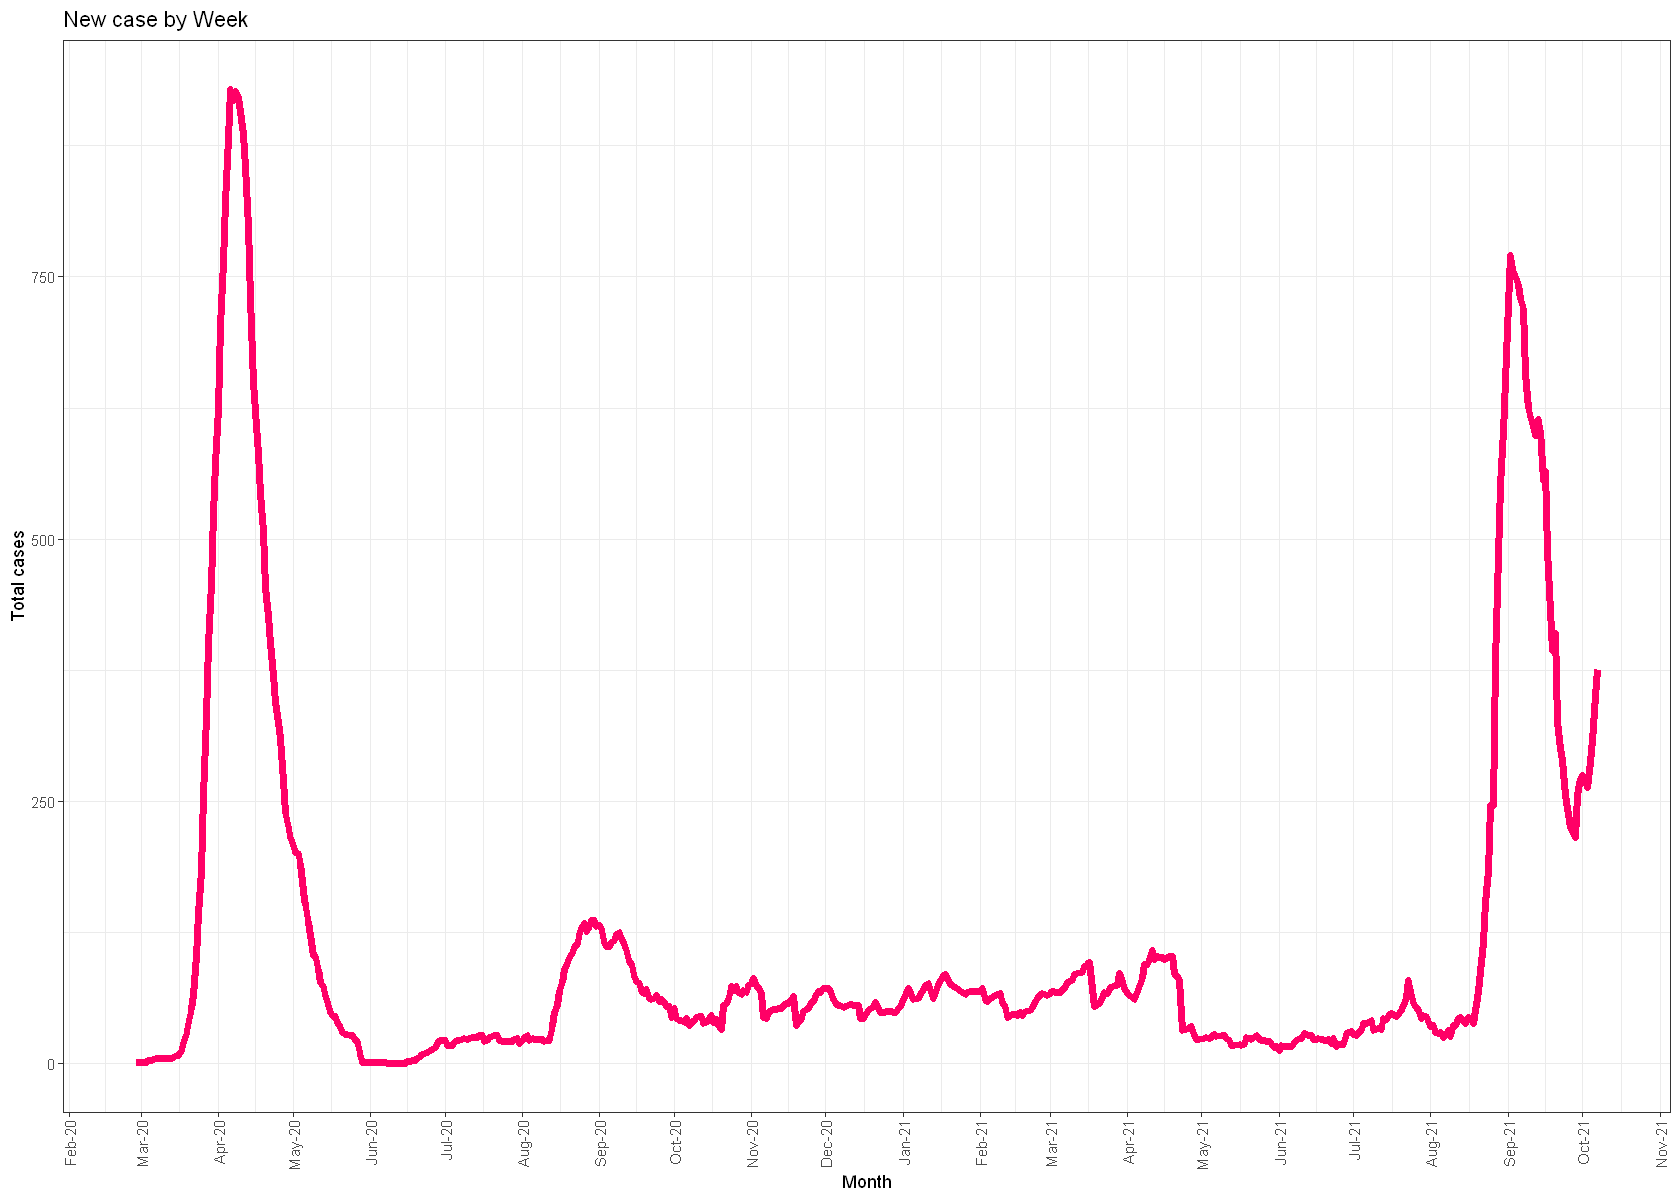

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message:
"Removed 6 rows containing missing values (position_stack)."


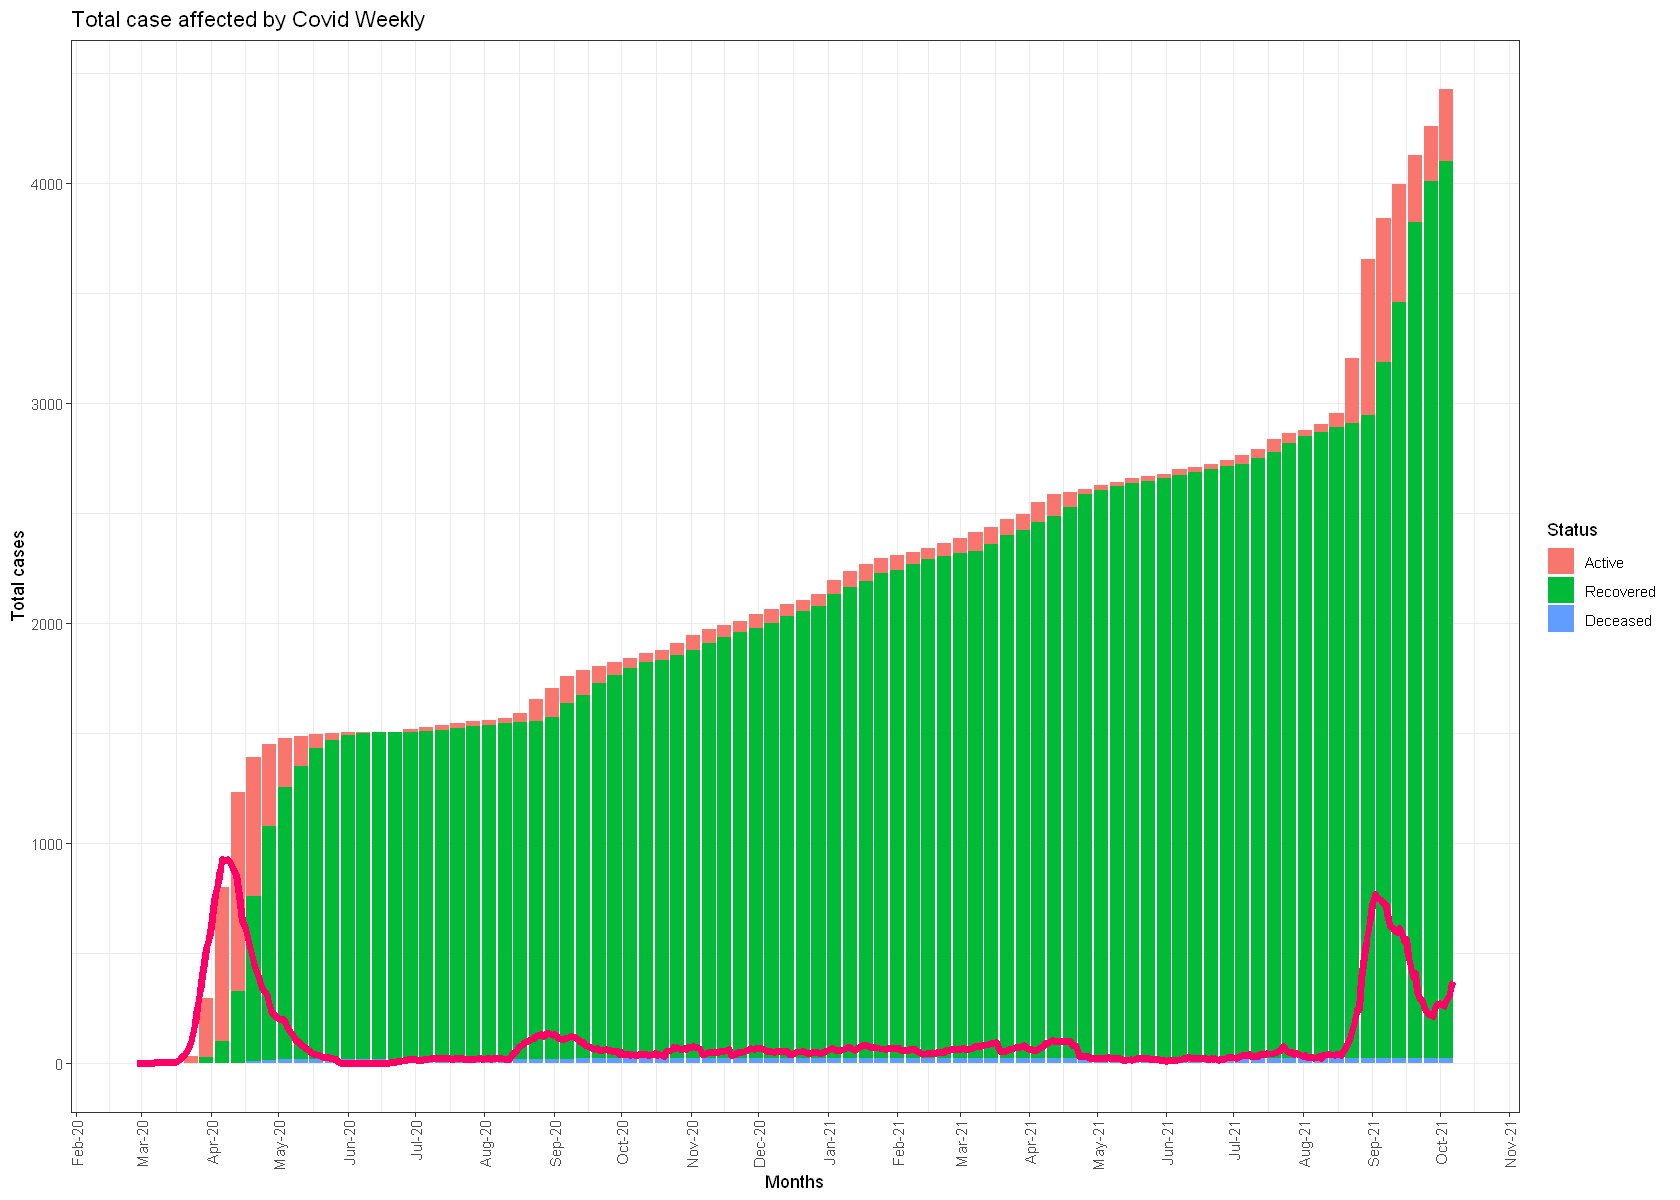

In [227]:
# Show Plots
new_case_plot
covid_weekly_plot

# Save Plots
savePlot("covid_new_case_weekly.png", new_case_plot)
savePlot("covid_case_weekly.png", covid_weekly_plot)